In [200]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

In [201]:
tram_data = pd.read_csv('../data/tram_complete.csv')

In [202]:
tram_growing_season = tram_data[((tram_data['date'] >= '2014-06-25') & (tram_data['date'] <= '2014-09-01')) |
                                 ((tram_data['date'] >= '2014-09-08') & (tram_data['date'] <= '2014-09-19')) |
                                 ((tram_data['date'] >= '2015-06-08') & (tram_data['date'] <= '2015-09-07')) |
                                 ((tram_data['date'] >= '2016-06-10') & (tram_data['date'] <= '2016-08-01')) |
                                 ((tram_data['date'] >= '2017-06-20') & (tram_data['date'] <= '2017-08-01'))]


In [250]:
tram_growing_season["ShortW_inc"].median()

227.202

In [203]:
tram_growing_season.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'DD_AKST', 'DD_Expected_AKST', 'Offset_time', 'DD_UTC', 'Run_number',
       'Stop_number', 'Height', 'ShortW_inc', 'ShortW_out', 'Albedo',
       'LongW_inc', 'LongW_out', 'Net_shortW', 'Net_longW', 'Net_Rad',
       'Sol_Irr_inc', 'Sol_Irr_out', 'PAR_inc', 'PAR_out', 'fPAR', 'Red_i',
       'NIR_i', 'Red_r', 'NIR_r', 'NDVI', 'T_air_C', 'T_surf_C', 'date',
       'Polygon_type', 'Topo_feature'],
      dtype='object')

In [204]:
tram_growing_season_daily = tram_growing_season.groupby(['date', 'Stop_number', 'Polygon_type', 'Topo_feature', 'Year'])[['Albedo', 'NDVI', 'T_surf_C', 'T_air_C']].mean().reset_index()

In [205]:
for year in [2014, 2015, 2016, 2017]:
    year_data = tram_growing_season_daily[tram_growing_season_daily['Year'] == year]
    print(f"{year}: {year_data['date'].min()} to {year_data['date'].max()}, n={len(year_data)}")

2014: 2014-06-25 to 2014-09-19, n=8887
2015: 2015-06-08 to 2015-09-07, n=10411
2016: 2016-06-10 to 2016-08-01, n=6516
2017: 2017-06-20 to 2017-07-22, n=4344


In [206]:
tram_growing_season_daily['DOY'] = pd.to_datetime(tram_growing_season_daily['date']).dt.dayofyear
tram_growing_season_daily['DOY_centered'] = tram_growing_season_daily['DOY'] - tram_growing_season_daily['DOY'].mean()

In [207]:
tram_growing_season_daily['Polygon_type'] = tram_growing_season_daily['Polygon_type'].astype('category')
tram_growing_season_daily['Topo_feature'] = tram_growing_season_daily['Topo_feature'].astype('category')

tram_growing_season_daily['T_surf_C_centered'] = tram_growing_season_daily['T_surf_C'] - tram_growing_season_daily['T_surf_C'].mean()
tram_growing_season_daily['NDVI_centered'] = tram_growing_season_daily['NDVI'] - tram_growing_season_daily['NDVI'].mean()

tram_growing_season_daily["Albedo_logit"] = np.log((tram_growing_season_daily["Albedo"] + 1e-6) / (1 - tram_growing_season_daily["Albedo"] + 1e-6))


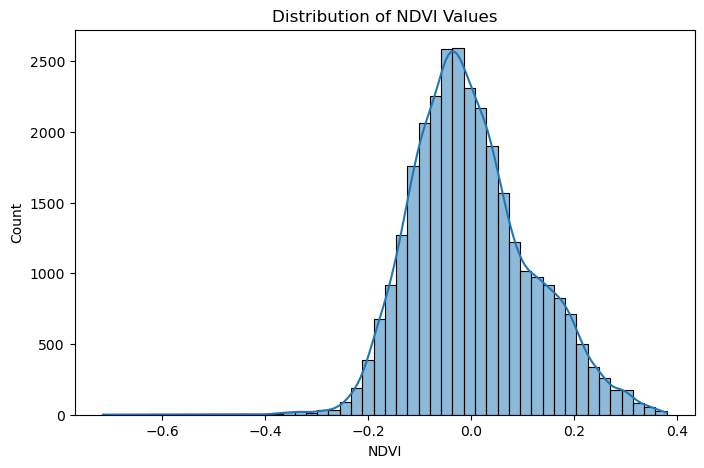

In [208]:
plt.figure(figsize=(8,5))
sns.histplot(tram_growing_season_daily['NDVI_centered'], bins=50, kde=True)
# plt.axvline(0.7, color='red', linestyle='--')
plt.title("Distribution of NDVI Values")
plt.xlabel("NDVI")
plt.ylabel("Count")
plt.show()


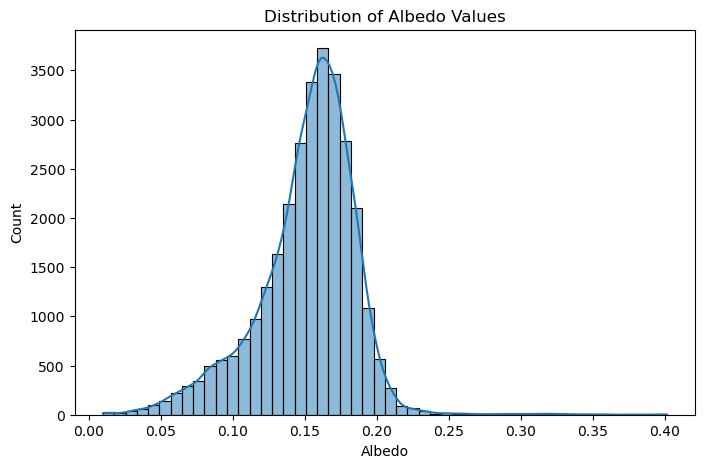

In [209]:
plt.figure(figsize=(8,5))
sns.histplot(tram_growing_season_daily['Albedo'], bins=50, kde=True)

# plt.axvline(0.7, color='red', linestyle='--')
plt.title("Distribution of Albedo Values")
plt.xlabel("Albedo")
plt.ylabel("Count")
plt.show()


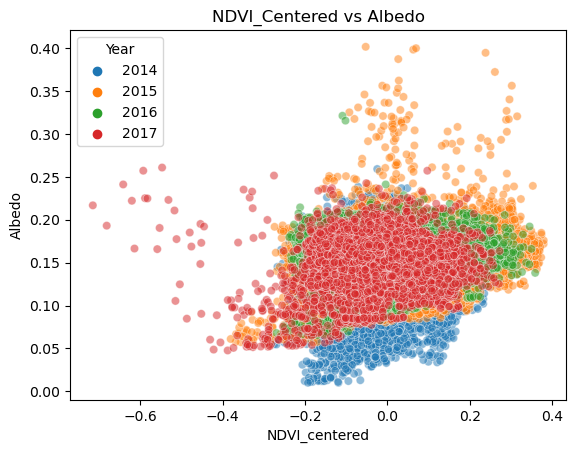

In [210]:
# Use seaborn scatterplot which supports 'hue' for categorical coloring by year
sns.scatterplot(data=tram_growing_season_daily, x='NDVI_centered', y='Albedo',
				hue=tram_growing_season_daily['Year'].astype(str), alpha=0.5, palette='tab10')

plt.title("NDVI_Centered vs Albedo")
plt.xlabel("NDVI_centered")
plt.ylabel("Albedo")
plt.legend(title='Year')
plt.show()

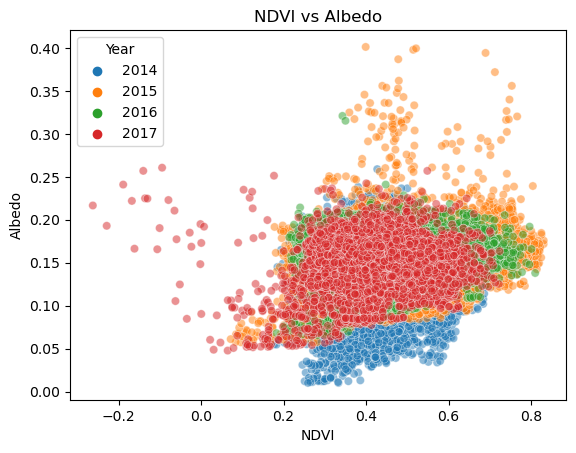

In [211]:
# Use seaborn scatterplot which supports 'hue' for categorical coloring by year
sns.scatterplot(data=tram_growing_season_daily, x='NDVI', y='Albedo',
				hue=tram_growing_season_daily['Year'].astype(str), alpha=0.5, palette='tab10')

plt.title("NDVI vs Albedo")
plt.xlabel("NDVI")
plt.ylabel("Albedo")
plt.legend(title='Year')
plt.show()

# Simple Model

In [212]:
simple_mixed_model = smf.mixedlm('Albedo ~ NDVI_centered + C(Polygon_type) * C(Topo_feature)', 
                          data=tram_growing_season_daily, 
                          groups=tram_growing_season_daily['Stop_number'])
simple_mixed_model_fit = simple_mixed_model.fit(reml=False) 
print(simple_mixed_model_fit.summary())

                           Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            Albedo    
No. Observations:              30158              Method:                        ML        
No. Groups:                    137                Scale:                         0.0006    
Min. group size:               120                Log-Likelihood:                68140.4365
Max. group size:               223                Converged:                     Yes       
Mean group size:               220.1                                                       
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         0.149    0.005 29.074 0.000  0.139  0.159
C(Polygon_type)

/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [213]:
simple_var_fixed = np.var(simple_mixed_model_fit.fittedvalues)
simple_var_random = float(simple_mixed_model_fit.cov_re.iloc[0,0])
simple_var_resid = simple_mixed_model_fit.scale

simple_r2_marginal = simple_var_fixed / (simple_var_fixed + simple_var_random + simple_var_resid)
simple_r2_conditional = (simple_var_fixed + simple_var_random) / (simple_var_fixed + simple_var_random + simple_var_resid)

print("Simple Model AIC:", simple_mixed_model_fit.aic)
print("Marginal R^2 (fixed effect):", round(simple_r2_marginal, 3))
print("Conditional R^2 (fixed + randoms):", round(simple_r2_conditional, 3))


Simple Model AIC: -136262.87308224896
Marginal R^2 (fixed effect): 0.35
Conditional R^2 (fixed + randoms): 0.59


# Model + NDVI * Year Interaction

In [214]:
mixed_model_year_interaction = smf.mixedlm('Albedo ~ NDVI_centered * C(Year) + C(Polygon_type) * C(Topo_feature)', 
                                  data=tram_growing_season_daily, 
                                  groups=tram_growing_season_daily['Stop_number'])
mixed_model_year_interaction_fit = mixed_model_year_interaction.fit(reml=False) 
print(mixed_model_year_interaction_fit.summary())


                           Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            Albedo    
No. Observations:              30158              Method:                        ML        
No. Groups:                    137                Scale:                         0.0005    
Min. group size:               120                Log-Likelihood:                71008.4519
Max. group size:               223                Converged:                     Yes       
Mean group size:               220.1                                                       
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         0.134    0.005 26.551 0.000  0.124  0.144
C(Year)[T.2015]

/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [215]:
var_fixed_year_interaction = np.var(mixed_model_year_interaction_fit.fittedvalues)
var_random_year_interaction = float(mixed_model_year_interaction_fit.cov_re.iloc[0,0])
var_resid_year_interaction = mixed_model_year_interaction_fit.scale

r2_marginal_year_interaction = var_fixed_year_interaction / (var_fixed_year_interaction + var_random_year_interaction + var_resid_year_interaction)
r2_conditional_year_interaction = (var_fixed_year_interaction + var_random_year_interaction) / (var_fixed_year_interaction + var_random_year_interaction + var_resid_year_interaction)

print("Marginal R² (fixed effect):", round(r2_marginal_year_interaction, 3))
print("Conditional R² (fixed + randoms):", round(r2_conditional_year_interaction, 3))

print("Year interaction AIC:", mixed_model_year_interaction_fit.aic)


Marginal R² (fixed effect): 0.424
Conditional R² (fixed + randoms): 0.659
Year interaction AIC: -141986.90383899357


# Model + DOY + C(Year) * NDVI

In [216]:
mixed_model_doy_year = smf.mixedlm('Albedo ~ NDVI_centered *C(Year)+ DOY_centered + C(Polygon_type) * C(Topo_feature)', 
                                   data=tram_growing_season_daily, 
                                   groups=tram_growing_season_daily['Stop_number'])
mixed_model_doy_year_fit = mixed_model_doy_year.fit(reml=False) 
print(mixed_model_doy_year_fit.summary())


                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Albedo    
No. Observations:             30158               Method:                         ML        
No. Groups:                   137                 Scale:                          0.0005    
Min. group size:              120                 Log-Likelihood:                 72410.2364
Max. group size:              223                 Converged:                      Yes       
Mean group size:              220.1                                                         
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         0.139    0.005  26.398 0.000  0.129  0.149
C(Yea

/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [217]:
var_fixed_doy_year = np.var(mixed_model_doy_year_fit.fittedvalues)
var_random_doy_year = float(mixed_model_doy_year_fit.cov_re.iloc[0,0])
var_resid_doy_year = mixed_model_doy_year_fit.scale

r2_marginal_doy_year = var_fixed_doy_year / (var_fixed_doy_year + var_random_doy_year + var_resid_doy_year)
r2_conditional_doy_year = (var_fixed_doy_year + var_random_doy_year) / (var_fixed_doy_year + var_random_doy_year + var_resid_doy_year)

print("Marginal R² (fixed effect):", round(r2_marginal_doy_year, 3))
print("Conditional R² (fixed + randoms):", round(r2_conditional_doy_year, 3))
print("Year interaction AIC:", mixed_model_doy_year_fit.aic)

Marginal R² (fixed effect): 0.446
Conditional R² (fixed + randoms): 0.696
Year interaction AIC: -144788.47284726938


# Best Fit Model REML = TRUE

In [244]:
mixed_model_doy_year = smf.mixedlm('Albedo ~ NDVI_centered *C(Year)+ DOY_centered + C(Polygon_type) * C(Topo_feature)', 
                                   data=tram_growing_season_daily, 
                                   groups=tram_growing_season_daily['Stop_number'])
mixed_model_doy_year_fit = mixed_model_doy_year.fit(reml=True) 
print(mixed_model_doy_year_fit.summary())

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Albedo    
No. Observations:             30158               Method:                         REML      
No. Groups:                   137                 Scale:                          0.0005    
Min. group size:              120                 Log-Likelihood:                 72331.1687
Max. group size:              223                 Converged:                      Yes       
Mean group size:              220.1                                                         
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         0.139    0.005  25.799 0.000  0.128  0.150
C(Yea

/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [245]:
print(f"DOY beta coefficent: {mixed_model_doy_year_fit.params['DOY_centered']:.6f}")

DOY beta coefficent: -0.000337


In [ ]:
# Extract coefficients from your fitted model
params = mixed_model_doy_year_fit.params
pvalues = mixed_model_doy_year_fit.pvalues

# Get the base NDVI coefficient and interaction terms
base_ndvi = params['NDVI_centered']
years = sorted(tram_growing_season_daily['Year'].unique())

# Calculate coefficient for each year
year_coefficients = {}
year_pvalues = {}

for year in years:
    if year == years[0]:  # Reference year
        year_coefficients[year] = base_ndvi
        year_pvalues[year] = pvalues['NDVI_centered']
    else:
        interaction_term = f'NDVI_centered:C(Year)[T.{year}]'
        if interaction_term in params.index:
            year_coefficients[year] = base_ndvi + params[interaction_term]
            year_pvalues[year] = pvalues[interaction_term]
        else:
            year_coefficients[year] = base_ndvi
            year_pvalues[year] = pvalues['NDVI_centered']


year_n = tram_growing_season_daily.groupby('Year').size()

print("Year-specific NDVI albedo relationships RELATIVE TO ZERO:")

print(f"{'Year':<8} {'beta_(NDVI)':<12} {'p-value':<15} {'n':<10}")

for year in years:
    coef = year_coefficients[year]
    pval = year_pvalues[year]
    n = year_n[year]
    print(f"{year:<8} {coef:<12.3f} {pval:<15.3e} {n:<10,}")



Year-specific NDVI albedo relationships RELATIVE TO ZERO:
Year     beta_(NDVI)  p-value         n         
2014     0.093        1.837e-270      8,887     
2015     0.102        6.291e-03       10,411    
2016     0.110        1.920e-06       6,516     
2017     0.088        1.968e-01       4,344     


In [224]:
years = sorted(tram_growing_season_daily['Year'].unique())

print(f"{'Year':<8} {'NDVI slope':<12} {'p vs zero':<15}")

for year in years:
    data_temp = tram_growing_season_daily.copy()
    data_temp['Year'] = pd.Categorical(data_temp['Year'], 
                                        categories=[year] + [y for y in years if y != year])
    
    model = smf.mixedlm('Albedo ~ NDVI_centered * C(Year) + DOY_centered + C(Polygon_type) * C(Topo_feature)',
                        data=data_temp,
                        groups=data_temp['Stop_number']).fit(reml=True)
    
    print(f"{year:<8} {model.params['NDVI_centered']:<12.4f} {model.pvalues['NDVI_centered']:<15.3e}")

Year     NDVI slope   p vs zero      


/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2014     0.0933       1.837e-270     


/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2015     0.1016       0.000e+00      


/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2016     0.1099       0.000e+00      
2017     0.0882       1.532e-179     


/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [239]:
pairwise_results = []

poly_types = ['LCP', 'FCP']
topo_features = ['rim', 'trough', 'center']

for topo_ref in topo_features:
    tram_copy = tram_growing_season_daily.copy()
    
    topo_order = [topo_ref] + [t for t in topo_features if t != topo_ref]
    tram_copy['Topo_feature'] = pd.Categorical(tram_copy['Topo_feature'], categories=topo_order)
    
    model = smf.mixedlm('Albedo ~ NDVI_centered * C(Year) + DOY_centered + C(Polygon_type) * C(Topo_feature)',
                        data = tram_copy,
                        groups = tram_copy['Stop_number']).fit(reml=True)
    
    coef = model.params['C(Polygon_type)[T.LCP]']
    pval = model.pvalues['C(Polygon_type)[T.LCP]']
    
    pairwise_results.append({
        'Comparison': f"FCP {topo_ref} vs LCP {topo_ref}",
        'Difference': coef,
        'p-value': pval
    })

df_pairwise = pd.DataFrame(pairwise_results)

print("FCP vs LCP at each topo position")
for _, row in df_pairwise.iterrows():
    print(f"  {row['Comparison']:<40} beta = {row['Difference']:>+.4f}   p = {row['p-value']:<10.4f} ")

/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


FCP vs LCP at each topo position
  FCP rim vs LCP rim                       beta = -0.0184   p = 0.0132     
  FCP trough vs LCP trough                 beta = -0.0047   p = 0.6945     
  FCP center vs LCP center                 beta = -0.0210   p = 0.0013     


/Users/colettebrown/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
